# 2D-CNN pipeline (images ready)

In [4]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import iqr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [1]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR


Mounted at /content/drive/


In [11]:
base_path = "/content/drive/MyDrive"
IMG_DIR = os.path.join(base_path, "images_16*16_proc_data/GADF_16_resamp_norm-1")
CSV_PATH = os.path.join(base_path, "target_train_488.csv")

In [5]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "RESAMP"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [7]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [ ]:
# # ====== CNN model (as in Table 2) ======
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

#         self.flattened = 512 * 2 * 2
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)
#         x = self.relu(self.conv2(x)); x = self.pool(x)
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
#         x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)

**16*16 2D CNN**

In [8]:
# =============================================
# ====== 6. CNN Model (16x16 Input) ======
# =============================================
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.flattened = 512 * 1 * 1
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
        x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [9]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [10]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)


========== Fold 1/5 ==========


Training Fold 1:   5%|▌         | 10/200 [00:09<03:07,  1.01it/s]

Epoch 10/200 | Train Loss: 0.7932 | Val Loss: 0.7946


Training Fold 1:  10%|█         | 20/200 [00:18<02:46,  1.08it/s]

Epoch 20/200 | Train Loss: 0.6610 | Val Loss: 0.6887


Training Fold 1:  15%|█▌        | 30/200 [00:28<02:38,  1.07it/s]

Epoch 30/200 | Train Loss: 0.5778 | Val Loss: 0.6462


Training Fold 1:  20%|██        | 40/200 [00:38<02:51,  1.07s/it]

Epoch 40/200 | Train Loss: 0.4378 | Val Loss: 0.5163


Training Fold 1:  25%|██▌       | 50/200 [00:48<02:30,  1.00s/it]

Epoch 50/200 | Train Loss: 0.3744 | Val Loss: 0.4874


Training Fold 1:  30%|███       | 60/200 [00:57<02:14,  1.04it/s]

Epoch 60/200 | Train Loss: 0.3075 | Val Loss: 0.4544


Training Fold 1:  32%|███▎      | 65/200 [01:04<02:14,  1.00it/s]


🛑 Early Stopping at epoch 66 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=3.828, R2=0.632, Bias=-1.267


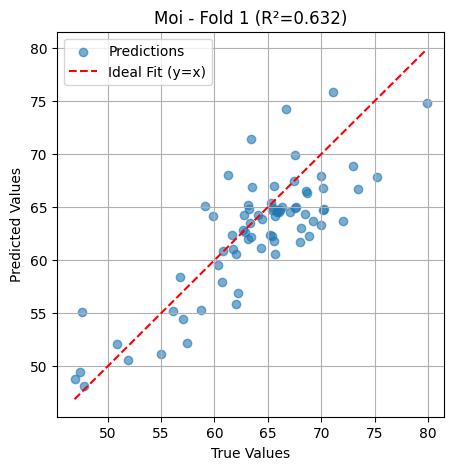

NDF: RMSE=3.914, R2=0.469, Bias=-0.886


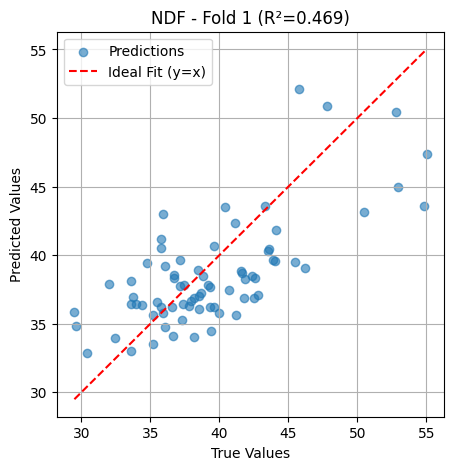

Starch: RMSE=6.477, R2=0.439, Bias=1.271


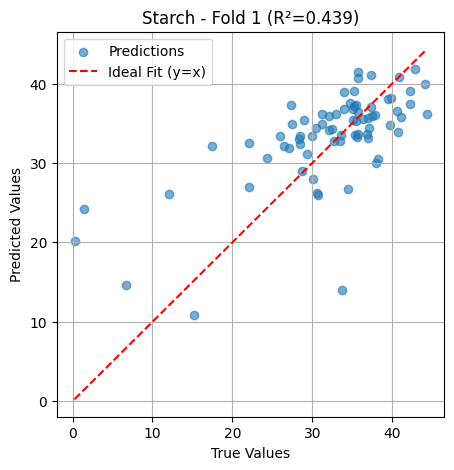


========== Fold 2/5 ==========


Training Fold 2:   5%|▌         | 10/200 [00:10<03:14,  1.02s/it]

Epoch 10/200 | Train Loss: 0.7837 | Val Loss: 0.8207


Training Fold 2:  10%|█         | 20/200 [00:20<03:02,  1.01s/it]

Epoch 20/200 | Train Loss: 0.6433 | Val Loss: 0.7026


Training Fold 2:  15%|█▌        | 30/200 [00:29<02:38,  1.07it/s]

Epoch 30/200 | Train Loss: 0.5515 | Val Loss: 0.5872


Training Fold 2:  20%|██        | 40/200 [00:40<02:41,  1.01s/it]

Epoch 40/200 | Train Loss: 0.4170 | Val Loss: 0.5004


Training Fold 2:  25%|██▌       | 50/200 [00:50<02:36,  1.05s/it]

Epoch 50/200 | Train Loss: 0.3118 | Val Loss: 0.4773


Training Fold 2:  30%|███       | 60/200 [01:00<02:22,  1.02s/it]

Epoch 60/200 | Train Loss: 0.2526 | Val Loss: 0.4750


Training Fold 2:  35%|███▌      | 70/200 [01:10<02:00,  1.08it/s]

Epoch 70/200 | Train Loss: 0.2743 | Val Loss: 0.5542


Training Fold 2:  40%|████      | 80/200 [01:20<01:51,  1.08it/s]

Epoch 80/200 | Train Loss: 0.2278 | Val Loss: 0.5323


Training Fold 2:  44%|████▍     | 89/200 [01:29<01:51,  1.01s/it]


🛑 Early Stopping at epoch 90 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=3.528, R2=0.701, Bias=1.078


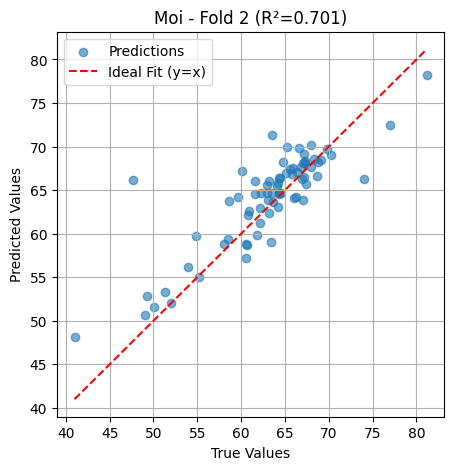

NDF: RMSE=4.238, R2=0.393, Bias=0.209


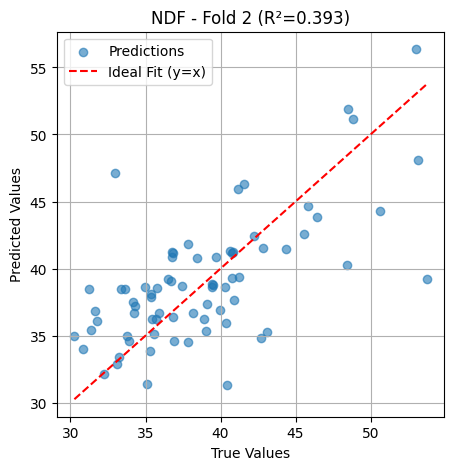

Starch: RMSE=6.214, R2=0.493, Bias=-0.008


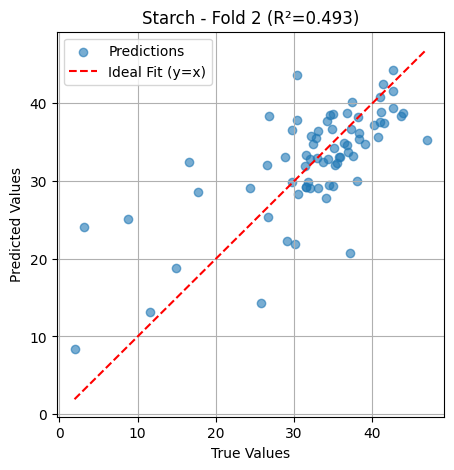


========== Fold 3/5 ==========


Training Fold 3:   5%|▌         | 10/200 [00:10<03:56,  1.24s/it]

Epoch 10/200 | Train Loss: 0.7180 | Val Loss: 0.9718


Training Fold 3:  10%|█         | 20/200 [00:19<02:45,  1.09it/s]

Epoch 20/200 | Train Loss: 0.6090 | Val Loss: 0.8561


Training Fold 3:  15%|█▌        | 30/200 [00:29<02:36,  1.09it/s]

Epoch 30/200 | Train Loss: 0.4518 | Val Loss: 0.7353


Training Fold 3:  20%|██        | 40/200 [00:38<02:33,  1.04it/s]

Epoch 40/200 | Train Loss: 0.3162 | Val Loss: 0.6953


Training Fold 3:  25%|██▌       | 50/200 [00:48<02:22,  1.05it/s]

Epoch 50/200 | Train Loss: 0.2605 | Val Loss: 0.7434


Training Fold 3:  29%|██▉       | 58/200 [00:56<02:18,  1.03it/s]


🛑 Early Stopping at epoch 59 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=3.067, R2=0.695, Bias=-0.287


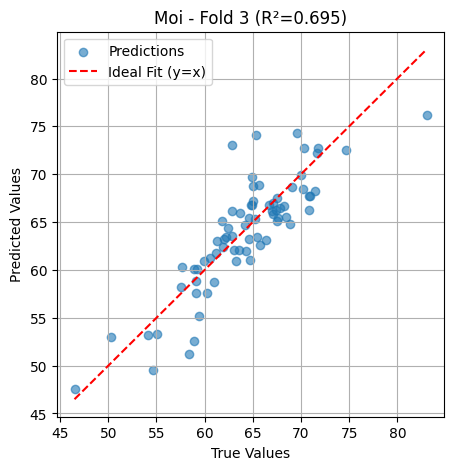

NDF: RMSE=7.383, R2=0.103, Bias=-0.268


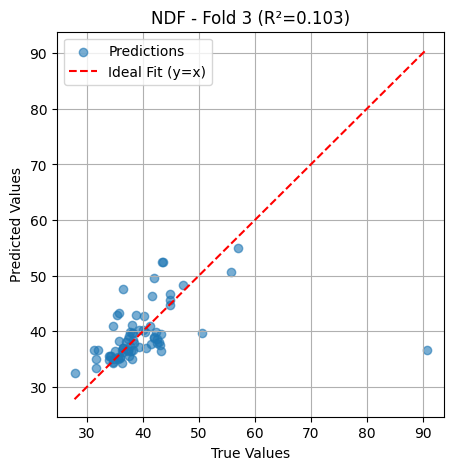

Starch: RMSE=6.513, R2=0.418, Bias=-0.290


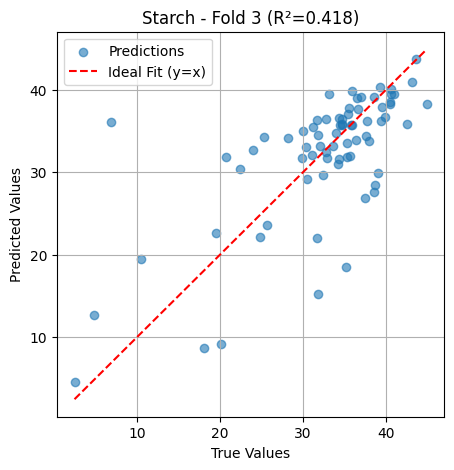


========== Fold 4/5 ==========


Training Fold 4:   5%|▌         | 10/200 [00:09<02:58,  1.06it/s]

Epoch 10/200 | Train Loss: 0.8292 | Val Loss: 0.7197


Training Fold 4:  10%|█         | 20/200 [00:19<03:01,  1.01s/it]

Epoch 20/200 | Train Loss: 0.6864 | Val Loss: 0.6885


Training Fold 4:  15%|█▌        | 30/200 [00:28<02:34,  1.10it/s]

Epoch 30/200 | Train Loss: 0.5249 | Val Loss: 0.5297


Training Fold 4:  20%|██        | 40/200 [00:37<02:27,  1.09it/s]

Epoch 40/200 | Train Loss: 0.4143 | Val Loss: 0.4763


Training Fold 4:  25%|██▌       | 50/200 [00:47<02:23,  1.04it/s]

Epoch 50/200 | Train Loss: 0.3558 | Val Loss: 0.4745


Training Fold 4:  30%|███       | 60/200 [00:58<02:25,  1.04s/it]

Epoch 60/200 | Train Loss: 0.2909 | Val Loss: 0.4478


Training Fold 4:  35%|███▌      | 70/200 [01:07<01:59,  1.09it/s]

Epoch 70/200 | Train Loss: 0.2609 | Val Loss: 0.4563


Training Fold 4:  40%|████      | 80/200 [01:16<01:51,  1.07it/s]

Epoch 80/200 | Train Loss: 0.2461 | Val Loss: 0.4162


Training Fold 4:  45%|████▌     | 90/200 [01:26<01:47,  1.03it/s]

Epoch 90/200 | Train Loss: 0.2193 | Val Loss: 0.4198


Training Fold 4:  50%|█████     | 100/200 [01:36<01:42,  1.03s/it]

Epoch 100/200 | Train Loss: 0.1972 | Val Loss: 0.4246


Training Fold 4:  55%|█████▌    | 110/200 [01:45<01:23,  1.08it/s]

Epoch 110/200 | Train Loss: 0.1680 | Val Loss: 0.3994


Training Fold 4:  55%|█████▌    | 110/200 [01:46<01:27,  1.03it/s]


🛑 Early Stopping at epoch 111 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=3.203, R2=0.710, Bias=-1.225


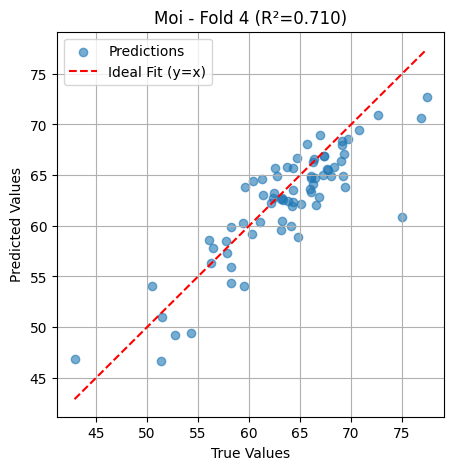

NDF: RMSE=3.954, R2=0.418, Bias=-0.327


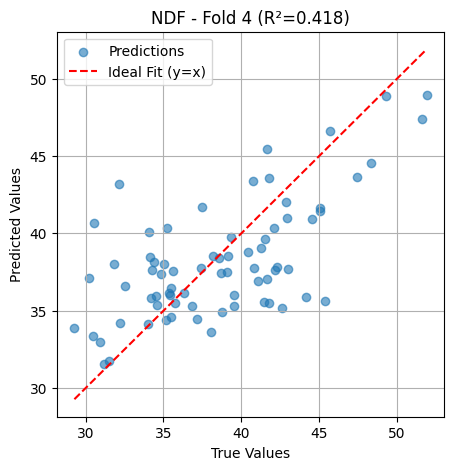

Starch: RMSE=5.971, R2=0.477, Bias=0.636


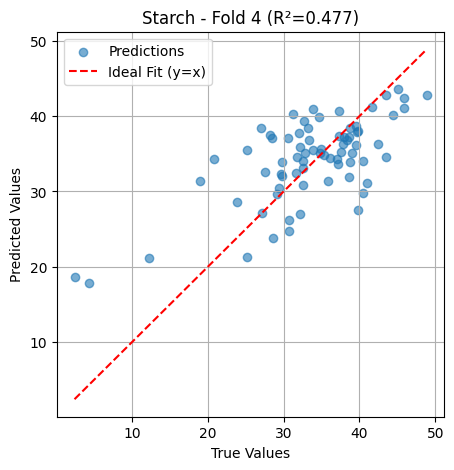


========== Fold 5/5 ==========


Training Fold 5:   5%|▌         | 10/200 [00:09<02:55,  1.08it/s]

Epoch 10/200 | Train Loss: 0.8265 | Val Loss: 0.5860


Training Fold 5:  10%|█         | 20/200 [00:19<02:51,  1.05it/s]

Epoch 20/200 | Train Loss: 0.6878 | Val Loss: 0.4706


Training Fold 5:  15%|█▌        | 30/200 [00:28<02:55,  1.03s/it]

Epoch 30/200 | Train Loss: 0.5730 | Val Loss: 0.4348


Training Fold 5:  20%|██        | 40/200 [00:38<02:27,  1.08it/s]

Epoch 40/200 | Train Loss: 0.4656 | Val Loss: 0.3743


Training Fold 5:  25%|██▌       | 50/200 [00:47<02:20,  1.07it/s]

Epoch 50/200 | Train Loss: 0.3755 | Val Loss: 0.3041


Training Fold 5:  30%|███       | 60/200 [00:57<02:14,  1.04it/s]

Epoch 60/200 | Train Loss: 0.3116 | Val Loss: 0.2952


Training Fold 5:  35%|███▌      | 70/200 [01:07<02:14,  1.03s/it]

Epoch 70/200 | Train Loss: 0.2677 | Val Loss: 0.3196


Training Fold 5:  36%|███▌      | 72/200 [01:09<02:04,  1.03it/s]


🛑 Early Stopping at epoch 73 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=2.838, R2=0.802, Bias=-0.374


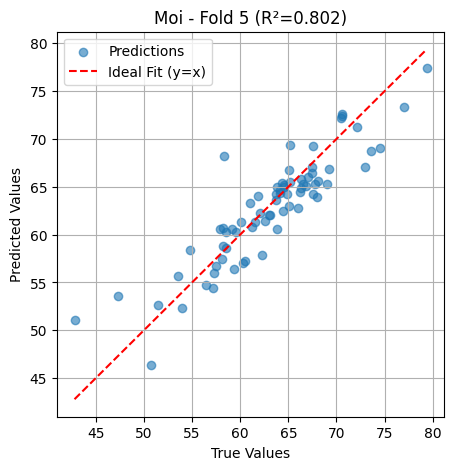

NDF: RMSE=4.129, R2=0.267, Bias=0.614


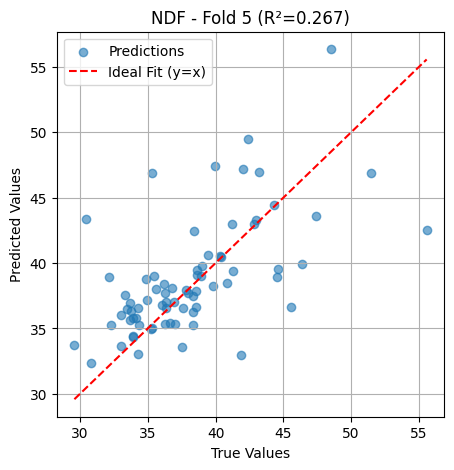

Starch: RMSE=5.584, R2=0.359, Bias=-0.545


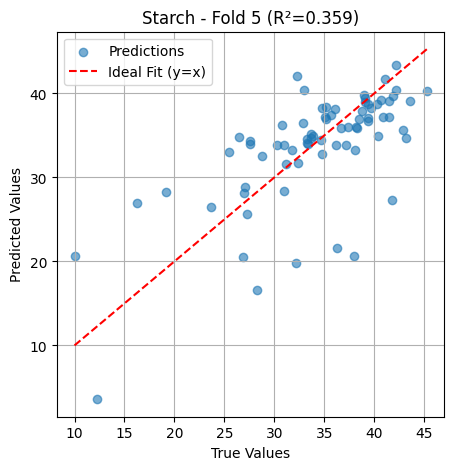



===== 📊 Average Results Across All Folds =====
Moi: Avg RMSE=3.293, Avg R2=0.708, Avg Bias=-0.415
NDF: Avg RMSE=4.724, Avg R2=0.330, Avg Bias=-0.132
Starch: Avg RMSE=6.152, Avg R2=0.437, Avg Bias=0.213


In [14]:
from tqdm import tqdm

# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# To store results for all folds
fold_metrics = {t: {'RMSE': [], 'R2': [], 'Bias': []} for t in TARGETS}

for fold, (t_idx, v_idx) in enumerate(kf.split(np.arange(len(trainval_idx)))):
    print(f"\n========== Fold {fold + 1}/{n_splits} ==========")

    # DataLoaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Early Stopping parameters =====
    best_val_loss = float('inf')
    patience = 15
    wait = 0
    best_model_state = None

    # ===== Training =====
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training Fold {fold + 1}"):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb.to(device))
                loss = criterion(preds, yb.to(device))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n🛑 Early Stopping at epoch {epoch} (no improvement for {patience} epochs)")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ===== Load best model =====
    model.load_state_dict(best_model_state)

    # ===== Validation (Final Metrics) =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        rmse, r2, bias = metrics[i]['RMSE'], metrics[i]['R2'], metrics[i]['Bias']
        fold_metrics[t]['RMSE'].append(rmse)
        fold_metrics[t]['R2'].append(r2)
        fold_metrics[t]['Bias'].append(bias)
        print(f"{t}: RMSE={rmse:.3f}, R2={r2:.3f}, Bias={bias:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5, 5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold + 1} (R²={r2:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

# =============================================
# ====== Average Metrics Across Folds ======
# =============================================
print("\n\n===== 📊 Average Results Across All Folds =====")
for t in TARGETS:
    avg_rmse = np.mean(fold_metrics[t]['RMSE'])
    avg_r2   = np.mean(fold_metrics[t]['R2'])
    avg_bias = np.mean(fold_metrics[t]['Bias'])
    print(f"{t}: Avg RMSE={avg_rmse:.3f}, Avg R2={avg_r2:.3f}, Avg Bias={avg_bias:.3f}")



=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.6888 | Val Loss: 0.6930
Epoch 20/200 | Train Loss: 0.5884 | Val Loss: 0.5356
Epoch 30/200 | Train Loss: 0.5367 | Val Loss: 0.4358
Epoch 40/200 | Train Loss: 0.3444 | Val Loss: 0.2648
Epoch 50/200 | Train Loss: 0.2836 | Val Loss: 0.2295
Epoch 60/200 | Train Loss: 0.2524 | Val Loss: 0.1842
Epoch 70/200 | Train Loss: 0.2432 | Val Loss: 0.1636
Epoch 80/200 | Train Loss: 0.1905 | Val Loss: 0.1471
Epoch 90/200 | Train Loss: 0.1789 | Val Loss: 0.1699
Epoch 100/200 | Train Loss: 0.1569 | Val Loss: 0.1178
Epoch 110/200 | Train Loss: 0.1541 | Val Loss: 0.1112
Epoch 120/200 | Train Loss: 0.1351 | Val Loss: 0.1081
Epoch 130/200 | Train Loss: 0.1163 | Val Loss: 0.0943
Epoch 140/200 | Train Loss: 0.1256 | Val Loss: 0.0945
Epoch 150/200 | Train Loss: 0.1166 | Val Loss: 0.0885
Epoch 160/200 | Train Loss: 0.0980 | Val Loss: 0.0850
Epoch 170/200 | Train Loss: 0.0868 | Val Loss: 0.0812
Epoch 180/200 | Train Loss: 0.0930 | Val Loss

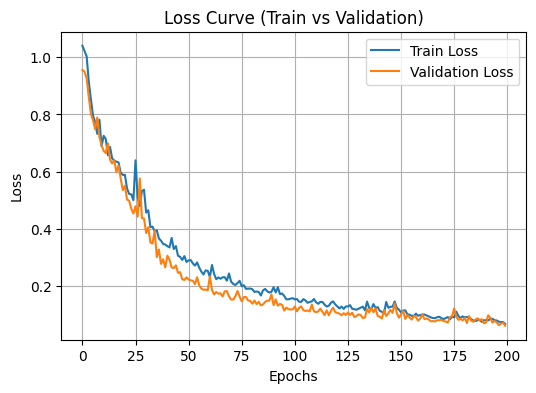

In [16]:
# =============================================
# ====== 10. Final Training with Loss Curve ======
# =============================================
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=seed)
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
val_losses   = []

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(final_loader))

    # Validation loss
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = final_model(xb)
            val_loss += criterion(preds, yb).item()
    val_losses.append(val_loss / len(val_loader))

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve (Train vs Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# =============================================
# ====== 11. Final Evaluation (Train/Val/Test) ======
# =============================================
def evaluate(model, loader, scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = scaler.inverse_transform(preds)
            yb_orig = scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred


train_true, train_pred = evaluate(final_model, final_loader, y_scaler)
val_true, val_pred     = evaluate(final_model, val_loader, y_scaler)
test_true, test_pred   = evaluate(final_model, test_loader, y_scaler)

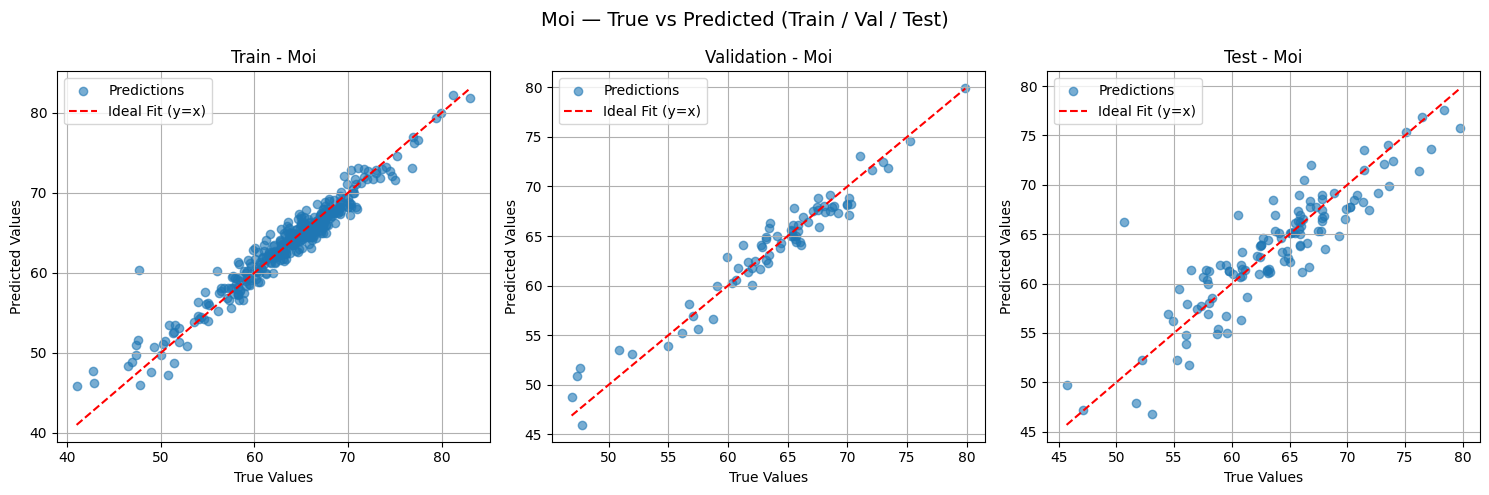

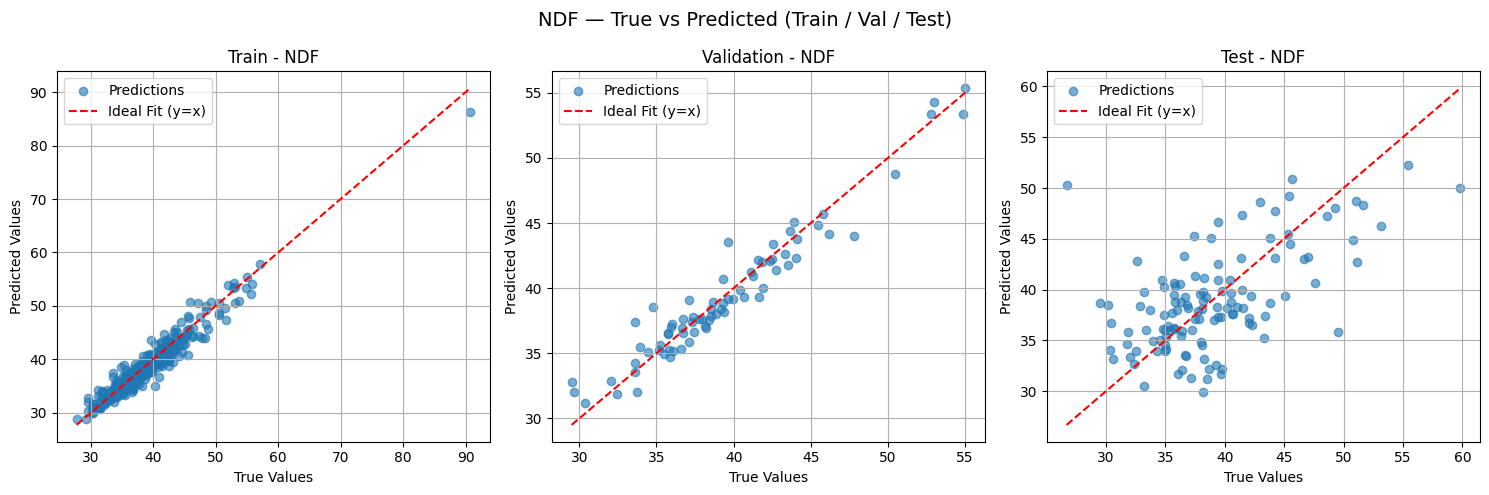

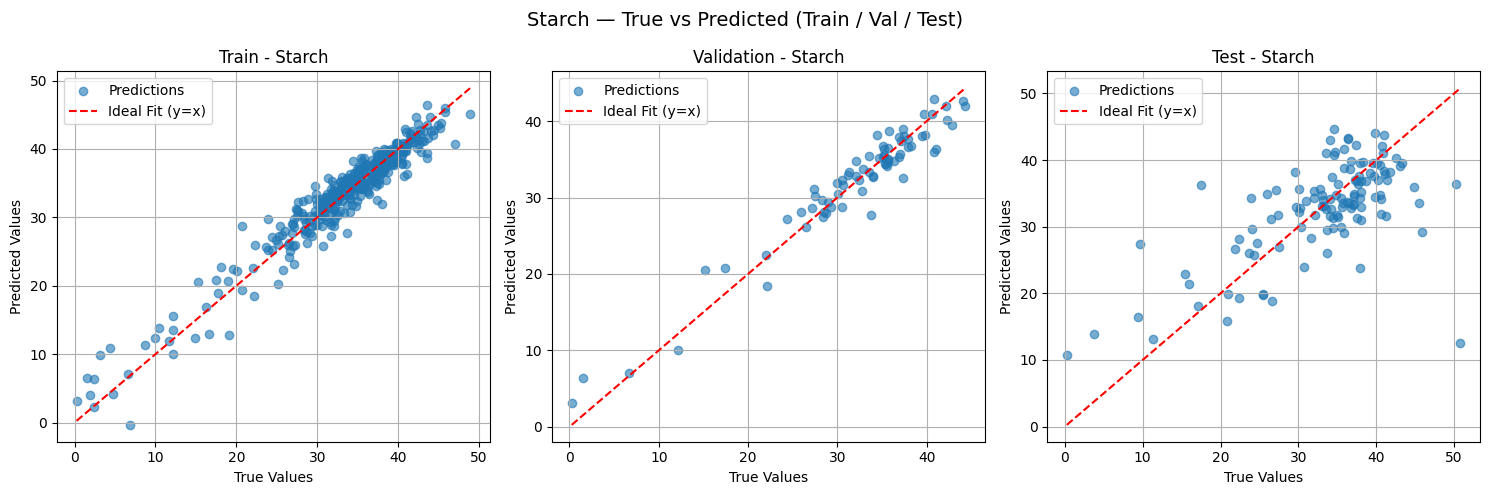

In [18]:
# =============================================
# ====== 12. Plot All Targets (Train/Val/Test) ======
# =============================================
for i, t in enumerate(TARGETS):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    datasets = [("Train", train_true, train_pred),
                ("Validation", val_true, val_pred),
                ("Test", test_true, test_pred)]

    for ax, (name, y_true, y_pred) in zip(axes, datasets):
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.set_title(f"{name} - {t}")
        ax.legend()
        ax.grid(True)

    plt.suptitle(f"{t} — True vs Predicted (Train / Val / Test)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [20]:
# =============================================
# ====== 13. Compute and Print Metrics ======
# =============================================
def print_metrics(name, y_true, y_pred):
    metrics = compute_metrics_orig(y_true, y_pred)
    print(f"\n📊 {name} Results:")
    for i, t in enumerate(TARGETS):
        rmse = metrics[i]['RMSE']
        r2   = metrics[i]['R2']
        bias = metrics[i]['Bias']
        print(f"🎯 {t}:")
        print(f"    RMSE: {rmse:.3f}")
        print(f"    R²: {r2:.3f}")
        print(f"    Bias: {bias:.3f}")

print_metrics("Train", train_true, train_pred)
print_metrics("Validation", val_true, val_pred)
print_metrics("Test", test_true, test_pred)



📊 Train Results:
🎯 Moi:
    RMSE: 1.528
    R²: 0.938
    Bias: 0.003
🎯 NDF:
    RMSE: 1.488
    R²: 0.935
    Bias: -0.231
🎯 Starch:
    RMSE: 2.151
    R²: 0.933
    Bias: 0.095

📊 Validation Results:
🎯 Moi:
    RMSE: 1.474
    R²: 0.945
    Bias: 0.034
🎯 NDF:
    RMSE: 1.391
    R²: 0.933
    Bias: -0.047
🎯 Starch:
    RMSE: 2.194
    R²: 0.936
    Bias: 0.067

📊 Test Results:
🎯 Moi:
    RMSE: 2.897
    R²: 0.786
    Bias: -0.254
🎯 NDF:
    RMSE: 4.880
    R²: 0.245
    Bias: -0.079
🎯 Starch:
    RMSE: 6.714
    R²: 0.395
    Bias: -0.397


In [ ]:
# =============================================
# ====== 14. Save Final Model ======
# =============================================
file_path = f"/content/CR_16_norm.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")

In [ ]:
# =============================================
# ====== 15. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
